In [34]:
## imports for the program
import os
import io
import csv
import zlib
import math
import time
import pickle
import base64
import joblib
import hashlib
import platform
import warnings

import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm import tqdm
from xgboost import plot_importance
from scipy.optimize import fmin_powell

# plot information in 3 dimensions
# from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import kaleido
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN, MeanShift, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, accuracy_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LinearRegression

# the pytorch module
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

# torch neural network items
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# changing the precision of the floating point operations
from torch.cuda.amp import GradScaler, autocast

# for visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# lime model evaluation
from lime import lime_tabular

# for encrypting the model and hashing it
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.scrypt import Scrypt
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives.asymmetric import padding
from cryptography.fernet import Fernet, MultiFernet




# code for xgboost found at https://www.kaggle.com/code/zeroblue/xgboost-with-optimized-offsets

# defining the device for cuda
if platform.system() == 'Darwin' and torch.backends.mps.is_available():
	
	# check if mps is available on mac
	device = torch.device('mps')  

elif torch.cuda.is_available():
	
	# check if cuda is available
    device = torch.device('cuda')  

else:
	
	# fallback to cpu if cuda is not available
	device = torch.device('cpu')  

# output the selected device
print(f"Using device: {device}")


Using device: mps


In [35]:
# global directory path
HOME_DIR = os.path.expanduser('~')

# the sub directory from the home direcotry
SUB_DIR = "Desktop/Classes/CPSC 471/Final Project/"

# directory that we should write info to
OUT_DIR = "models/node_importance_delta"

# where we are writing files to
WRITE_DIR = os.path.join(
	HOME_DIR,
	SUB_DIR,
	OUT_DIR
)

BASELINE_SAVE_FILE_NAME = "manipulate_nn.pth"

# get the batch size
BATCH_SIZE = 64

MAX_INDICIES_LEN_PLOTTING = 500

# getting the colors for the plots 
PLOT_COLOR_1 = "darkorange"
PLOT_COLOR_2 = "dodgerblue"

# whether we should save the images
SHOULD_SAVE_OUTPUT = True
NUM_CLASSES = 10

In [36]:
# load the data
print("Load the data using pandas")
train = pd.read_csv("../final_471_datasets/train.csv")
test = pd.read_csv("../final_471_datasets/test.csv")

# global variables
columns_to_drop = ['Id', 'Response'] #, 'Medical_History_10','Medical_History_24']
xgb_num_rounds = 720
missing_indicator = -1000

# training and testing temp dataframes
temp_train = train
temp_test = test

# getting all of the data
all_data = pd.concat([temp_train, temp_test], ignore_index=True)

# create new variable for product first and second character
all_data['Product_Info_2'] = all_data.Product_Info_2.astype(str)
all_data['Product_Info_2_char'] = all_data["Product_Info_2"].str[0]
all_data['Product_Info_2_num'] = all_data["Product_Info_2"].str[1]

# factorize the categorical variables
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

# get the combined BMI age variable
all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

# checking for how many medical keywords were found in each patient diagnosis
med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

# remove the missing values
print('Eliminate missing values')    
all_data.fillna(missing_indicator, inplace=True)

# fix the dtype on the label column
all_data['Response'] = all_data['Response'].astype(int)

# split train and test
train = all_data[all_data['Response']>0].copy()
test = all_data[all_data['Response']<1].copy()


Load the data using pandas
Eliminate missing values


In [37]:
# now create a neural network without any of the explainability features that we want to integrate

# just pull the data from before
train_data = all_data[all_data['Response'] > 0].copy()
test_data = all_data[all_data['Response'] < 1].copy()

# split the data into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    train_data.drop(columns=columns_to_drop, axis=1),
    train_data['Response'],
    test_size=0.2,
    random_state=42
)

# scale the data appropriately
scaler = StandardScaler()

# fit and transform the data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# load the insurance dataset in 
class InsuranceDataset(Dataset):

    # initialize the features and the labels
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    # define the length function
    def __len__(self):
        return len(self.features)

    # get the item defined by an index
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.long) - 1  # Assuming labels are 1-indexed


# define an object for the insurance test and train datasets
train_dataset = InsuranceDataset(X_train_scaled, y_train.values)
val_dataset = InsuranceDataset(X_val_scaled, y_val.values)

# include the validation dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)






# compute the principal components of the data that we are trying to train the machine learning model on 
# all_data: this is all of the data that we are going to run the principal component analysis on
# n_components: the number of components that the PCA should generate for us
# should_scale: this defines whether we should scale the data that we are considering or not using the standard scaler
def compute_PCA(all_data, n_components=10, scale_data=False):

    # check the data type to make sure that it is good
    if not isinstance(all_data, torch.Tensor):
        all_data = torch.tensor(all_data, dtype=torch.float)

    # compute the principal components
    if scale_data:
        std_scaler = StandardScaler()
        all_data = std_scaler.fit_transform(all_data)

    # run the pca
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(all_data)

    # return the principal components
    return pca, torch.from_numpy(principal_components).float()




# function for getting all of the features of the data together for computation
def get_all_features(train_loader):

    # get the matrix that we are going to be using to compute the mahalanobis distance
    # start by getting all of the data from the loader
    features_list = []
    labels_list = []

    for features, labels in tqdm(train_loader, desc="Retrieving data from loader"):
        features_list.append(features)
        labels_list.append(labels)

    # concatenate all of the inputs that we are going to be using together
    all_features = torch.cat(features_list, dim=0)

    # get a tensor out of it
    all_features = all_features.clone().detach()
    
    # concatenate all of the inputs that we are going to be using together
    all_labels = torch.cat(labels_list, dim=0)
    all_labels = all_labels.clone().detach()

    return (all_features, all_labels)


# function to visualize the PCA so that we can better understand the data that we are training on
def visualize_pca(pca_features, labels, centroids):

    # transfer the labels to numpy
    labels = np.array(labels)
    
    # class colors
    matplotlib_colors = [
        'b',  
        'g',  
        'r',  
        'c',  
        'm',  
        'y',  
        'orange',
        'purple',
        'brown',
        'pink',
        'gray',
        'olive',
        'cyan',
        'lime',
        'maroon',
        'navy',
        'teal',
        'coral'
    ]

    # get the number of labels that we are going to plot
    # print(f"Number of labels: {len(set(labels))}")

    # get the number of components that we are ploting
    num_components = pca_features.shape[1]
    num_plots = num_components // 3

    # create subplots
    for plot_index in range(num_plots):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # getting the compoennts that we ar egoing to be plotting
        component_start = plot_index * 3
        component_end = component_start + 3

        # create the figure
        fig = go.Figure()

        # plot the PCA figures
        for label in tqdm(set(labels), desc=f"Plotting labeled data points in subplot {plot_index}"):

            # get all of the points from a certain label
            indices = np.where(labels == label)[0]

            # sample a maximum number of the points
            if len(indices) > MAX_INDICIES_LEN_PLOTTING:
                indices = np.random.choice(indices, MAX_INDICIES_LEN_PLOTTING, replace=False)

            # print(f"Plotting {len(indices)} points for label {label} in subplot {plot_index}...")

            # fix the label features to fix it if we had too. many
            label_features = pca_features[indices, component_start:component_end]

            # plot the dots
            try:
                # plt.scatter(label_features[:, 0], 
                #             label_features[:, 1], 
                #             color=matplotlib_colors[label], 
                #             label=f'Class {label}', 
                #             s=10)

                fig.add_trace(go.Scatter3d(
                    x=label_features[:, 0], 
                    y=label_features[:, 1], 
                    z=label_features[:, 2],
                    mode='markers',
                    marker=dict(size=3),
                    name=f'Class {label}'
                ))
            except Exception as e:
                print(f"Failed: {e}")
        
        # plot the centroids to show where they are
        for i, centroid in enumerate(centroids):
            if centroid.shape[0] > component_end:
                fig.add_trace(go.Scatter3d(
                    x=[centroid[component_start]],
                    y=[centroid[component_start+1]],
                    z=[centroid[component_start+2]],
                    mode='markers',
                    marker=dict(symbol='x', size=5, color='black'),
                    name=f'Centroid {i + 1}'
                ))
                # print(f'Centroid {i + 1} at {centroid[component_start]} {centroid[component_start+1]} {centroid[component_start+2]}')

        # put the information on the plots
        # ax.set_title(f'3D PCA Plot of Components {component_start+1} to {component_end}')
        # ax.set_xlabel('Component {}'.format(component_start + 1))
        # ax.set_ylabel('Component {}'.format(component_start + 2))
        # ax.set_zlabel('Component {}'.format(component_start + 3))
        # ax.legend()

        fig.update_layout(
            title=f'3D PCA Plot of Components {component_start+1} to {component_end}',
            scene=dict(
                xaxis_title=f'Component {component_start + 1}',
                yaxis_title=f'Component {component_start + 2}',
                zaxis_title=f'Component {component_start + 3}'
            ),
            legend_title="Legend",
            autosize=False,
            width=700,
            height=700,
        )

        # plot the title as neede
        # plt.title('PCA of Training Data')
        # plt.xlabel('Principal Component 1')
        # plt.ylabel('Principal Component 2')
        # plt.legend()
        # plt.grid(True)
        fig.show()

        # now save the plot to a png
        # fig.write_image(os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, f"pca_subplot_{plot_index}.png"))

        # display the image
        # display(Image(filename=os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, f"pca_subplot_{plot_index}.png")))



# prepare the test data (normalize and load into DataLoader)
X_test_scaled = scaler.transform(test_data.drop(columns=['Response', 'Id'] + columns_to_drop, axis=1))
test_dataset = InsuranceDataset(X_test_scaled, np.zeros((X_test_scaled.shape[0],)))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# getting all of the data
(all_train_features, all_train_labels) = get_all_features(train_loader)
(all_val_features, all_val_labels) = get_all_features(val_loader)
(all_test_features, all_test_labels) = get_all_features(test_loader)


# pca_model, pca_train_features = compute_PCA(all_train_features)
# pca_val_features = torch.from_numpy(pca_model.transform(all_val_features)).float()

# saving the model if we have trained it
# if TRAIN_MODEL:
   
# run PCA on the data
pca_model, pca_train_features = compute_PCA(all_train_features)
pca_val_features = torch.from_numpy(pca_model.transform(all_val_features)).float()
pca_test_features = torch.from_numpy(pca_model.transform(all_test_features)).float()

# else:
   
    # load the PCA model in 
    # pca_model = joblib.load(os.path.join(curr_run_dir, 'pca_model.joblib'))

# # check if we should save the model to a runthrough
# if SHOULD_SAVE_OUTPUT:
#     print(f"Saving PCA")
#     joblib.dump(pca_model, os.path.join(curr_run_dir, 'pca_model.joblib'))



# checking the shapes
# print(f"all_train_features shape: {all_train_features.shape}")
# print(f"pca_components shape: {pca_train_features.shape}")
# print(f"inverse transform shape: {pca_model.inverse_transform(pca_train_features).shape}")
# print(f"all_train_labels shape: {all_train_labels.shape}")

# turn the training data into a dataset
pca_train_loader = TensorDataset(pca_train_features, all_train_labels)
pca_val_loader = TensorDataset(pca_val_features, all_val_labels)
pca_test_loader = TensorDataset(pca_test_features, all_test_labels)

# define the loaders
pca_train_loader = DataLoader(pca_train_loader, batch_size=BATCH_SIZE, shuffle=True)
pca_val_loader = DataLoader(pca_val_loader, batch_size=BATCH_SIZE, shuffle=False)
pca_test_loader = DataLoader(pca_test_loader, batch_size=BATCH_SIZE, shuffle=False)

# now get the k centroids that would represent the center of the clusters that
# I would get if I ran a k-means clustering algorithm
print(f"Computing theoretical clustering centroids...")

Retrieving data from loader: 100%|██████████| 309/309 [00:00<00:00, 1609.12it/s]


Computing theoretical clustering centroids...


In [38]:

# these are helper functions that help us to monitor the output of the neural network layers and 
# attach hooks to the neural network that helps us get the forward pass values
network_layer_outputs = []
current_pass_through = []

# define the hook to get the forward pass through the neural network
def get_layer_output_hook(module, input, output):

    global current_pass_through

    # append the output of this passthrough to the total array
    current_pass_through.append(output.cpu().detach())  

# register the hooks with the network
def register_hooks(model):

    print(f"Registering hooks...")

    # check each of the layers for somewhere where we can register a hook
    for layer in model.children():

        # check for an instance of a layer
        if isinstance(layer, nn.Module):

            # register a forward hook
            layer.register_forward_hook(get_layer_output_hook)

            # give the staus
            # print(f"Registered a forward hook at: {layer}")

# start a new pass of the model that we are running
def start_new_pass_through():
    global current_pass_through
    current_pass_through = []

# clear the current pass through
def save_and_clear_current_pass_through():
    global network_layer_outputs, current_pass_through
    network_layer_outputs.append(current_pass_through)

    start_new_pass_through()

# this function entirely wipes the storage of the intermediate values
def clear_total_run():
    global network_layer_outputs
    network_layer_outputs = []

# function to return and clear the entire training series
def retrieve_and_return_entire_network_outputs():
    global network_layer_outputs
    t_ret = network_layer_outputs
    network_layer_outputs = []
    return t_ret

In [39]:
# neural network for the insurance dataset
# as a baseline for the model
class InsuranceNN(nn.Module):

    # initialize the insurance neural network item
    def __init__(self):
        super(InsuranceNN, self).__init__()
        self.fc1 = nn.Linear(pca_train_features.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, NUM_CLASSES)  

    # go forward through the neural network
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    # this function returns the probabilities for different classes from the neural network model
    def predict_proba(self, x, device='cpu'):
        
        # set the network to evaluation mode
        self.eval()  
        
        with torch.no_grad():
        
            # pass through the model
            x = x.to(device)
            outputs = self(x)

            # get the probabilities
            out_probs = F.softmax(outputs, dim=1)

            return out_probs

    # defining a fit function to appease the marginal probability regression function
    def fit(self, train_loader, epochs, optimizer, criterion, device='cpu'):
        
        # move everything to devices
        self.to(device)
        self.train()

        # iterate through some amount of epochs to train the model
        for epoch in range(epochs):

            for inputs, labels in train_loader:
            
                # move everything to the right devices
                inputs = inputs.to(device) 
                labels = labels.to(device)

                # reset the optimizer that we are using
                optimizer.zero_grad()
                outputs = self(inputs)

                # calc the loss
                loss = criterion(outputs, labels)
                
                # backprop the loss
                loss.backward()
                optimizer.step()
            
            # print epoch information
            print(f'epoch: {epoch+1}/{epochs} | loss: {loss.item():.4f}')

# initialize the model
baseline_model = InsuranceNN()

# register the hooks that are going to keep track of the outputs of the model activations
# register_hooks(baseline_model)

# Start of Importance Reduction Formula

This is the start of the development of the importance reduction equation which will lower the importance of certain inputs to the network. We are going to try a series of analyses to try to understand how to optimally remove the influence of a single input on the neural network that we are considering. We are going to try to find how long each of the methods that we detail takes along with the degradation in accuracy compared to baseline. Some methods that we plan to explore are below, but there likely will not be enough time to explore all of the method:

- simple retraining: this is going to serve as the baseline that we compare the rest of the methdos that we try against. We are going to remove one of the inputs from the model, and train the model to see how the model does along with how long it takes. 
- stochastic fine-tuning: this method takes the original dataset and fine-tunes the model where the input feature that we are trying to mask has a stochastic value in place of the real value for each instance that we process in the dataset.
- inversion fine-tuning: similar to the stochastic method, this method takes the input tensors that we used to originally train the model but changes the feature that we are trying to remove to an inverted version of the original data point. That is, given the original datapoint feature $x$ and the mean of the feature over the entire dataset $x'$, we fine-tune the model using the save input data but with x changed to $x = x - 2 \cdot (x - x')$. We explore whether using the mean is the optimal configuration as well. 
- amplitude-influence reduction: in this method, we actually manipulate the weights of the model to try to approximate the original output of the model while enforcing all weights coming out of the node that we target in the model remain equal to 0. If the node hthat we are tring to limit the influence of is an inut node, then we can fine-tune the model after to ensure that the output is approximated as closely as possible. Otherwise, we simply have to keep the model as is after the weight manipulation or the concept could become dispersed through other nodes and flow to a later layer. 
- amplitude-influence reduction (extended): an extension of this method would be to use the covariance of the individual activations from layer $i-1$ to supplement the removal of a single node in layer $i-1$ totally. In order to do this, I find the covariance of all of the outputs of the layer and greedily add influenece from the nodes that have the highest magnitude covariance on all of the outputs that have lost the influence of the selected node. I adjust the bias in the process if possible as well. 

Epoch 1, Loss: 1.5982894714555702, Val Loss: 1.5537215317449262
Epoch 2, Loss: 1.5279000447223197, Val Loss: 1.5362117194360303
Epoch 3, Loss: 1.5151426702296589, Val Loss: 1.5275614139854268
Epoch 4, Loss: 1.5076358754734331, Val Loss: 1.5283082973572515
Epoch 5, Loss: 1.5030933562390416, Val Loss: 1.525053507538252
Epoch 6, Loss: 1.4986782688472025, Val Loss: 1.5156062937551928
Epoch 7, Loss: 1.4950573895211816, Val Loss: 1.517134117182865
Epoch 8, Loss: 1.4907070277998296, Val Loss: 1.51801819955149
Epoch 9, Loss: 1.4881717439936437, Val Loss: 1.509587457744024
Epoch 10, Loss: 1.485563982864729, Val Loss: 1.5096005329521753
Epoch 11, Loss: 1.484020602173632, Val Loss: 1.5105500791662483
Epoch 12, Loss: 1.481883042753946, Val Loss: 1.5086235557833025
Epoch 13, Loss: 1.4802515635098936, Val Loss: 1.5082722543388285
Epoch 14, Loss: 1.4774030283354174, Val Loss: 1.5069311222722452
Epoch 15, Loss: 1.4756396314176865, Val Loss: 1.509356160958608
Epoch 16, Loss: 1.4743535863599098, Val Los

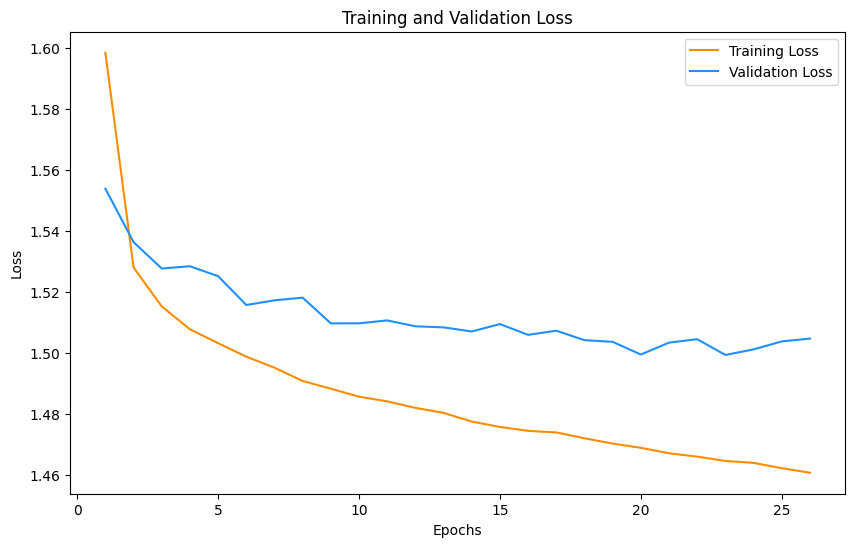

In [40]:
# start by defining a model that we are going to analyze and change

##
# this function is used to train the neural network that we are going to be using for classification of the items that 
# we are considering for insurance and for prisoners
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, patience=2):
    best_val_loss = float('inf')
    patience_counter = 0

    # lists to store loss values for plotting
    train_losses = []
    val_losses = []
    epochs_list = []


    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        # print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

        train_losses.append(epoch_loss)
        val_losses.append(epoch_val_loss)
        epochs_list.append(epoch + 1)

        # check if the validation loss improved
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
        
        else:
            patience_counter += 1

        # check for early stopping
        if patience_counter > patience:
            print("Stopping early due to increasing validation loss.")
            break

        # print the statistics from this epoch
        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}')

    # plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_list, train_losses, label='Training Loss', color=PLOT_COLOR_1)
    plt.plot(epochs_list, val_losses, label='Validation Loss', color=PLOT_COLOR_2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if SHOULD_SAVE_OUTPUT:
        plt.savefig(os.path.join(WRITE_DIR, "nn_loss.png"))

    plt.show()


# define the criteria and optimizer that we are going to be using to train the neural network
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

# training the model
train_model(baseline_model, pca_train_loader, pca_val_loader, loss_function, optimizer, epochs=30)

# saving the model to a state dictionary
torch.save(baseline_model, os.path.join(WRITE_DIR, BASELINE_SAVE_FILE_NAME))

In [110]:
# starting from index zero for each
# this is the last PCA component
# in the first layer
FEATURE_NUM = 9
LAYER_NUM = 0


# # this function computes the relevance of a single node+feature combination in the neural network
# # layer_num: this is the layer number of the node that we are targeting
# # feature_num: the number of the node that we want to minimize the importance of
# def compute_single_feature_importance(input_model, data_loader, layer_num, feature_num):

# 	# compute the total model importance

# define a function to get the importance of some input feature or node that we want to target
# it effectively uses a method for layer relevance propagation
# and takes the average relevance over all of the input data that we can give it
# input_model: this is the model that we are going to compute the importance in 
def compute_importance(input_model, data_loader):

	# go through and get the one-hot importance of each input
	loss_func = nn.CrossEntropyLoss()

	input_model.eval()

	# go through and add the hooks that take care of logging the activations
	# and the outputs of the layers that we are considering
	layer_activations = []

	all_layer_avg_relevances = None
	number_considered = 0

	# this adds a hook to each layer of the model to get the activation
	def forward_hook(module, input, output):

		# add to the linear and relus only
		if isinstance(module, nn.ReLU) or isinstance(module, nn.Linear):
			layer_activations.append(output)


	# add the hooks to the model
	model_layer_hooks = []

	# iterate the layers
	for layer in input_model.modules():

		# register the hook
		t_hook = layer.register_forward_hook(forward_hook)
		model_layer_hooks.append(t_hook)


	# setting model to train
	input_model.train()
		
	# array to keep track of all of the gradients in the model
	total_gradient_list = []

	# compute the gradients
	for input_data, input_label in data_loader:

		# set the gradients of the model to zero
		input_model.zero_grad()

		# # get the output from the model
		# model_guess = input_model(input_data)

		# # compute the loss
		# r_loss = loss_func(model_guess, input_label)

		# # backpropagate the error
		# r_loss.backward()

		# # keep track of the gradients
		# for param in input_model.parameters():
				
		# 		# check if this is something that we should consider
		# 		if param.grad is not None:
					
		# 			# store the abs gradients
		# 			total_gradient_list.append(param.grad.abs())

		# get no gradient
		with torch.no_grad():
			
			# get the output from the model
			model_guess = input_model(input_data)
		
		# now get the relevance with respect to this input and update the mean values
		layer_relevance = model_guess
		instance_total_layer_activations = [layer_relevance.mean(dim=0)]

		
		# # initialize all of the relevances if this has not been called yet
		# if all_layer_avg_relevances is None:
		# 	all_layer_avg_relevances = [torch.zeros_like(act) for act in layer_activations]

		# getting the number of activations
		print(f"Number of layer activations: {len(layer_activations)}")
		

		# iterate through all of the possible activations in the model
		for i in range(len(layer_activations)-1, 0, -1):

			print(f"Checking layer {i}")

			# get the current and previous activations to get the relevance
			current_activation = layer_activations[i]
			previous_activation = layer_activations[i-1] if i > 0 else input_data

			# get the current layer of the model
			current_layer = list(input_model.children())[i]

			# look for the linear weights to propagate the relevance
			if isinstance(current_layer, nn.Linear):
				
				# get the weights of the model
				weights = current_layer.weight.data

				# this applies the z-rule to the layer to compute the resulting relevances
				# print(f"processing: {previous_activation.shape} {torch.clamp(weights, min=0).T.shape}")
				z_rule_z_val = torch.matmul(previous_activation, torch.clamp(weights, min=0).T) + 1e-10
				z_rule_s_val = layer_relevance / z_rule_z_val
				z_rule_c_val = torch.matmul(z_rule_s_val, torch.clamp(weights, min=0))
				
				# propagate relevance to the previous layer
				layer_relevance = previous_activation * z_rule_c_val 
				
				# print(f"previous_activation length: {len(previous_activation)}")
				# print(f"z_rule_c_val: {z_rule_c_val.shape}")
				# print(f"layer_relevance shape: {layer_relevance.mean(dim=0).shape}")

				# add the relevance to the array
				instance_total_layer_activations.append(layer_relevance.mean(dim=0))

		
		
		# if we have not added anything then just make these values the relevance values
		if not all_layer_avg_relevances:
			all_layer_avg_relevances = instance_total_layer_activations
		
		# otherwise then compute the new averages
		else:
			for l_idx in range(len(all_layer_avg_relevances)):
				# print(f"{instance_total_layer_activations[l_idx].shape}")
				all_layer_avg_relevances[l_idx] += instance_total_layer_activations[l_idx]

		# increment the number of examples that we have considered
		number_considered += 1

		# clear the layer activations
		layer_activations.clear()

	# average out the relevances
	dat, _ = next(iter(data_loader))
	batch_size = dat.shape[0]
	all_layer_avg_relevances = [relevance / (number_considered) for relevance in all_layer_avg_relevances]


	# remove all of the hooks from the model
	for t_hook in model_layer_hooks:
		t_hook.remove()

	# return the initial layer relevance
	all_layer_avg_relevances.reverse()
	return [r.cpu().numpy() for r in all_layer_avg_relevances]	


# first bit of importance computation
initial_importance = compute_importance(baseline_model, pca_train_loader)
print(f"Initial importance of feature {FEATURE_NUM} in layer {LAYER_NUM}: {initial_importance}")

Number of layer activations: 3
Checking layer 2
processing: torch.Size([64, 32]) torch.Size([32, 10])
Checking layer 1
processing: torch.Size([64, 64]) torch.Size([64, 32])
Number of layer activations: 3
Checking layer 2
processing: torch.Size([64, 32]) torch.Size([32, 10])
Checking layer 1
processing: torch.Size([64, 64]) torch.Size([64, 32])
torch.Size([10])
torch.Size([32])
torch.Size([64])
Number of layer activations: 3
Checking layer 2
processing: torch.Size([64, 32]) torch.Size([32, 10])
Checking layer 1
processing: torch.Size([64, 64]) torch.Size([64, 32])
torch.Size([10])
torch.Size([32])
torch.Size([64])
Number of layer activations: 3
Checking layer 2
processing: torch.Size([64, 32]) torch.Size([32, 10])
Checking layer 1
processing: torch.Size([64, 64]) torch.Size([64, 32])
torch.Size([10])
torch.Size([32])
torch.Size([64])
Number of layer activations: 3
Checking layer 2
processing: torch.Size([64, 32]) torch.Size([32, 10])
Checking layer 1
processing: torch.Size([64, 64]) tor

In [ ]:
# now set a target node that we are going to try to minimize the effect of
# method_function: the method that we are using to try to remove the influence
# input_model:
# layer:
# node_num:
def remove_influence(method_function, input_model, layer, node_num):

	# print the method that we ar eusing
	print(f"Removing influence with {method_function.__name__}")

	# get the timer going
	start_time = time.time()

	# run the function
 	# each of the functions shoudl return a dictionary with at least the accuracy of the model that came out of the method
	ret_dict = method_function(input_model, layer, node_num)

	# get the end time
	end_time = time.time()

	# print how long that took
	print(f"Took {(end_time - start_time):.4f} seconds")


